# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST 데이터셋 
###### 머신러닝 분야의 hello world

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 'data', 'target': numpy 배열로 반환 
* 'frame': 데이터프레임으로 반환
* 'feature_names': 픽셀에 대한 이름
* 'target_names': 0부터9까지의 숫자 클래스
* 'DESCR': MNIST에 대한 상세 정보
* 'details': openml에 대한 메타data
* 'categories': 픽셀은 0~255 사이 정수값이기 때문에 범주값 부재
* 'url': openml 웹사이트의 주소

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

#data는 2차원 배열이기 때문에 대문자 X 부여

(70000, 784)

In [4]:
y.shape

(70000,)

> 70000개의 샘플이 784개의 특성 픽셀(28*28)

### 샘플로 그려보기

그림 저장: some_digit_plot


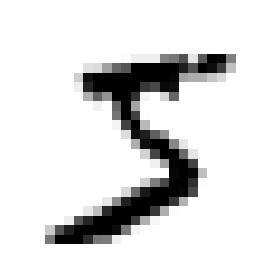

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) # 2차원 배열로 변환(numpy배열이라 reshape함수 사용 가능)
plt.imshow(some_digit_image, cmap=mpl.cm.binary) # cmap = 'binary'흑백 반전
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [8]:
y[0]

'5'

> 제대로 레이블된 것을 확인

In [9]:
type(y[0])

str

#### 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

In [11]:
y = y.astype(np.uint8)
type(y[0])

numpy.uint8

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

### 훈련집합 테스트집합 분할

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# 이미 트레인셋과 테스트셋이 분리되어 60000개는 트레인셋 뒤 10000개는 테스트셋으로 가이드되어 있음

# 이진 분류기 훈련

In [15]:
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)
# True와 False를 구분

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

* SGDClassifier는 확률적 경사 하강법 분류 알고리즘으로 4강에서 상세 설명
* SGD는 무작위성 사용하기에 결과 재현 위해선 random state 매개변수 지정

In [18]:
sgd_clf.predict([some_digit])
# some_digit은 X[0]으로 5임
# 사이킷런의 predict 메소드는 데이터를 2차원 배열을 가정하기에 some_digit에 []를 씌워 2차원 배열로 전달

array([ True])

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# 성능 측정

### 교차 검증 사용한 정확도 측정

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=skfolds, scoring="accuracy")

array([0.9669 , 0.91625, 0.96785])

> cv = skfolds 만 입력해도 위 for문 생략 가능

In [22]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

* 5가 아님을 판별하는 분류기 생성
* 모두 정확도 90%를 넘지만 모든 이미지 중 단10%만이 5이기 때문에 성능이 좋다고 할 수 없음
* 양성 클래스가 적을 때 이러한 문제가 나타남 (불균형한 데이터셋)
* 따라서, 정확도만을 갖고 모델의 성능을 평가하기 어려움!

### 오차 행렬 (혼동 행렬)

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

![혼동행렬](https://t1.daumcdn.net/cfile/tistory/99F53C395CFE3EA919)

뒤 N, P 먼저 읽으면: 
   * TN(음성이로 예측했는데 진짜 음성임)
   * FP(양성으로 예측했는데 틀렸고 음성임)
   * FN(음성으로 예측했는데 틀렸고 양성임)
   * TP(양성으로 예측했는데 진짜 양성임)

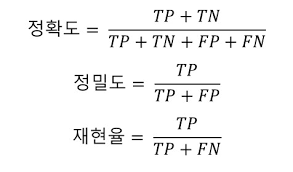

#### 정밀도(Precison)

양성으로 예측한 것으로만 계산

#### 재현율(Recall)

실제 양성 데이터로만 계산

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### f1스코어 (정밀도와 재현율의 조화평균)

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 정밀도 / 재현율 트레이드오프

분류 예측 메소드가 decision function을 호출하고 threshold 기준으로 분류

임곗값이 높을수록 재현율은 낮아지고 반대로 정밀도는 높아짐

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#### 결정 임곗값에 대한 정밀도재현율

그림 저장: precision_recall_vs_threshold_plot


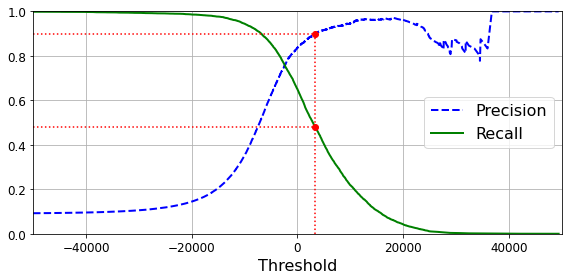

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

#### 정밀도재현율곡선

그림 저장: precision_vs_recall_plot


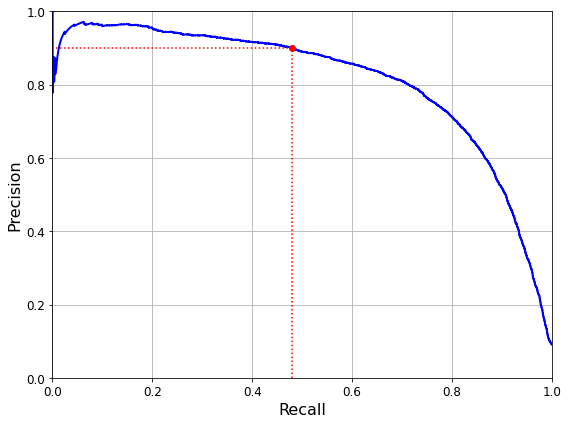

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

> 그래프가 오른쪽에 붙으면 붙을수록 좋은 모델

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #정밀도 90을 목표로 했을 때 임곗값

In [40]:
threshold_90_precision

3370.0194991439557

In [42]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC 곡선

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


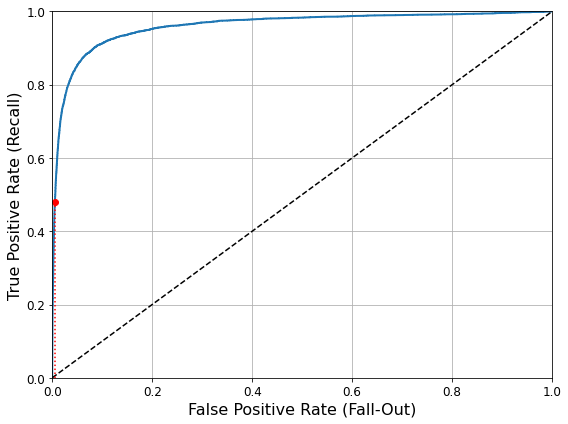

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## 랜덤포리스트로 훈련

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
# predict_proba는 예측이 아닌 예측의 확률값 반환

In [48]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


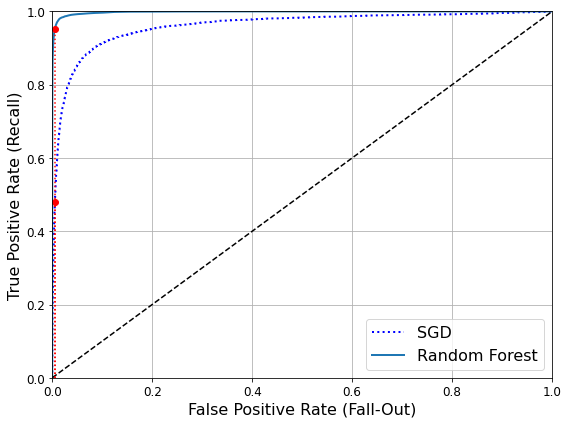

In [49]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 다중 분류

* OvR, OvA: N개 모델 훈련
* OvO: N(N-1)/2개 훈련

In [53]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

#SVC 서포트 벡터 머신은 5강에서 자세한 설명

array([5], dtype=uint8)

In [54]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

> SVC는 현재 45개 이진 분류기를 훈련시켜 각 결점 점수를 얻고 가장 높은 클래스를 반환한 것

In [55]:
np.argmax(some_digit_scores)

5

In [56]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [57]:
svm_clf.classes_[5]

5

### OvR전략 사용 강제

In [58]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
len(ovr_clf.estimators_)
#만든 분류기의 개수

10

In [61]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [63]:
sgd_clf.decision_function([some_digit])
# SGDClassifier를 이용해 훈련해도 OvR 전략에 따라 10개 분류기 생성

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

> cross_validate() 함수를 사용하는 편

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

> (당연하지만) 전처리를 한 후 훈련을 실행하면 결과가 더 좋게 나옴

## 에러 분석 (오차 행렬 활용)

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

그림 저장: confusion_matrix_plot


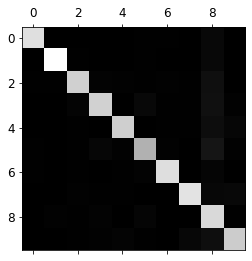

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()
#이미지로 표현

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

그림 저장: confusion_matrix_errors_plot


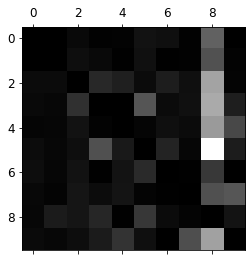

In [69]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

## 다중 레이블 분류

* 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])
# some_digit은 5이기 때문에 7보다 작으니 F, 홀수니까 T

array([[False,  True]])

In [74]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred, average="macro")

## 다중 출력 분류

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


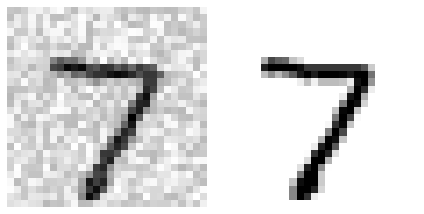

In [76]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()
#노이즈 섞어 만든 이미지 출력

그림 저장: cleaned_digit_example_plot


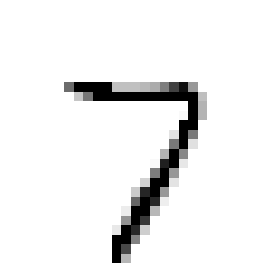

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")
#각 픽셀(레이블)에 다중 클래스(0~255)부여 ?